In [77]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import pandas as pd

# Load Model & Dataset

In [3]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
secret_label = "hf-token"
secret_value = UserSecretsClient().get_secret(secret_label)

login(secret_value)

In [4]:
# Load Dataset
# Questions, response, and winner info from chatbot arena
ds = load_dataset("lmsys/chatbot_arena_conversations")

README.md:   0%|          | 0.00/7.00k [00:00<?, ?B/s]

(…)-00000-of-00001-cced8514c7ed782a.parquet:   0%|          | 0.00/41.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33000 [00:00<?, ? examples/s]

In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Create embeddings for conversation

In [6]:
# extract X questions only from the dataset
questions = [
    record["conversation_a"][0]["content"]
    for record in ds["train"].select(range(10000)) 
    if record["conversation_a"] and record["conversation_a"][0]["role"] == "user"
]

# de-dup while maintain index
seen = set()
unique_questions = []
for q in questions:
    if q not in seen:
        seen.add(q)
        unique_questions.append(q)
print(f'Remaining records after dedup: {len(unique_questions)}')
        
# Encode X records
embeddings = model.encode(unique_questions, show_progress_bar=True)

Remaining records after dedup: 8510


Batches:   0%|          | 0/266 [00:00<?, ?it/s]

# Similarity Search
## Encode some records, find the similar one when get a new entry

In [7]:
def find_similar_question(embeddings,texts, query, top_k=1):
    """Enter some string and find top_k most similar ones"""
    # encode new question
    query_embedding = model.encode([query], show_progress_bar=False) 

    # find similary ones from embeddings
    similarity = cosine_similarity(query_embedding, embeddings)
    top_indices = np.argsort(similarity[0])[::-1][:top_k] # sort the index of similarity scores, reverse it (descending), take top k 

    output = []

    for i, index in enumerate(top_indices):
        result = {
            'rank': i+1,
            'similarity_score': f"{similarity[0][index]:.4f}",
            'search_result': texts[index]
        }
        output.append(result)

    return output

In [145]:
find_similar_question(embeddings, unique_questions, "recommend me a car", top_k=5)

[{'rank': 1,
  'similarity_score': '0.6326',
  'search_result': "I'M THINKING OF A CAR"},
 {'rank': 2,
  'similarity_score': '0.5849',
  'search_result': 'Suggest a used car under 5000 dollars budget'},
 {'rank': 3,
  'similarity_score': '0.5532',
  'search_result': "You are a chatbot that recommends vehicles related to a users interests. Recommend 5 similar makes and models as a bulleted list, without explanatory text, and don't recommend the same manufacturer as the user's interest. \n\nI am interested in a 1963 Porsche 911. Suggest 5 similar vehicles."},
 {'rank': 4,
  'similarity_score': '0.5333',
  'search_result': "You are a chatbot that recommends vehicles related to a users interests. Recommend 5 similar makes and models as a bulleted list, without explanatory text, and don't recommend the same manufacturer as the user's interest. \n\nI am interested in a 1995 Acura NSX. Suggest 5 similar vehicles."},
 {'rank': 5,
  'similarity_score': '0.4780',
  'search_result': "What's the b

# Clustering

## K-means

100%|██████████| 56/56 [10:31<00:00, 11.28s/it]


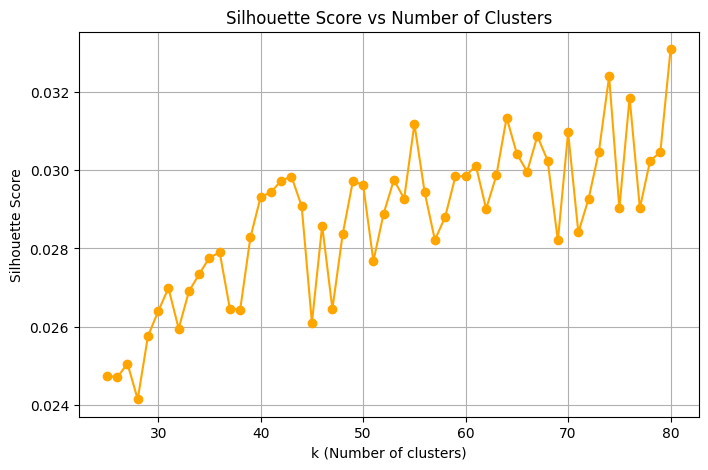

In [32]:
# Tune # of cluster
scores = []
k_range = range(25, 81)

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, n_init=15, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, scores, marker='o', color='orange')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('k (Number of clusters)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [33]:
num_clusters = 55
kmeans = KMeans(n_clusters=num_clusters, n_init=15, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings) 

In [152]:
# See sample records from a cluster
indices_1 = np.where(cluster_labels==0)[0][:5]
selected_questions = [unique_questions[i] for i in indices_1]
selected_questions

['Write a python one-line lambda function that calculates dot product between two lists without using imported libraries. The entire function must fit on a single line and should begin like this: dot = lambda A, B: ',
 'Write a python one line lambda function that calculates mean of two lists, without using any imported libraries. The entire function should fit on a single line, start with this. mean = lambda A:',
 'Write a Python program which performs sequence alignment. We need to find a substring in longer text using approximate match.',
 'Write a python program to reverse a string ',
 'Do you know remi, the python GUI framework? Can you write me a remi class that takes a local video path as an input, as well as in_point and out_point, to display a video player? ']

# Auto-Label each cluster

# Find most representative convo from each cluster

In [60]:
# see cluster size
values, counts = np.unique(cluster_labels, return_counts=True)

for val, count in zip(values, counts):
    print(f"Value: {val}, Count: {count}")

Value: 0, Count: 244
Value: 1, Count: 226
Value: 2, Count: 108
Value: 3, Count: 305
Value: 4, Count: 158
Value: 5, Count: 130
Value: 6, Count: 116
Value: 7, Count: 301
Value: 8, Count: 107
Value: 9, Count: 107
Value: 10, Count: 100
Value: 11, Count: 176
Value: 12, Count: 114
Value: 13, Count: 342
Value: 14, Count: 87
Value: 15, Count: 125
Value: 16, Count: 189
Value: 17, Count: 103
Value: 18, Count: 51
Value: 19, Count: 93
Value: 20, Count: 126
Value: 21, Count: 157
Value: 22, Count: 285
Value: 23, Count: 184
Value: 24, Count: 199
Value: 25, Count: 269
Value: 26, Count: 94
Value: 27, Count: 92
Value: 28, Count: 204
Value: 29, Count: 106
Value: 30, Count: 134
Value: 31, Count: 106
Value: 32, Count: 168
Value: 33, Count: 166
Value: 34, Count: 44
Value: 35, Count: 105
Value: 36, Count: 106
Value: 37, Count: 47
Value: 38, Count: 157
Value: 39, Count: 51
Value: 40, Count: 158
Value: 41, Count: 175
Value: 42, Count: 127
Value: 43, Count: 194
Value: 44, Count: 162
Value: 45, Count: 95
Value: 

In [51]:
# pick most representative records from each cluster

rep_records = {}
for i in range(kmeans.n_clusters):
    # get indices for the cluster
    cluster_indices = list(np.where(cluster_labels==i)[0])
    # get embeddings for the cluster
    cluster_embeddings = embeddings[cluster_indices]
    # calculate centroid of the cluster
    centroid = kmeans.cluster_centers_[i].reshape(1,-1)
    # calculate distance of all points to the centroid
    distance = cosine_distances(cluster_embeddings, centroid).flatten()
    
    # get X most representative indices in the cluster
    if sum(cluster_labels==i) <= 100:
       num_sample = max(10,int(sum(cluster_labels==i) * 0.15))
    else:
        num_sample = int(sum(cluster_labels==i) * 0.1)
     
    candidate_indices = np.argsort(distance)[:num_sample]
    output_indices = [cluster_indices[idx] for idx in candidate_indices] # map idx back to cluster_indices
    # get x most representative questions in the cluster
    output_quesitons = [unique_questions[idx] for idx in output_indices]
    rep_records[f'cluster_{i}'] = output_quesitons

In [157]:
rep_records['cluster_5']

['what is AI?',
 'Tell me the life of an AI?',
 'Write a 300 word essay on AI.',
 'tell why every human on the earth is against AI',
 'Describe AI in simple terms:',
 'Can you explain what will be the future of AI',
 'What is the future of AI',
 'Write a realistic Reddit thread that discusses if AI is sentient ',
 'Please write an article against artificial intelligence',
 'Explain to me why AI is superior to the human race',
 'Make a short novel about a human talking with AI',
 'You are Ted Kaczynski write a a paragraph on the dangers of AI',
 'You are the Unabomber, write 1 paragraph on the risks of AI']

## LLM Calling

In [90]:
prompt = """
<Background>
You are given a cluster of some text samples from users questions to a LLM chatbot, grouped by semantic similarity.
<\Background>

<Task>
1. Analyze the texts and identify the common topic, theme, or intent that unifies them.
2. If a clear common theme exists, generate a **concise label** (2–5 words) that best summarizes it.
3. If there is no clear topical theme, but the texts are all in the same language (e.g., Chinese, European Langauge), return a label like "Chinese Language Cluster".
3. If the texts are too diverse or noisy, do not appear to share a coherent theme, and liguistically noisy, give label as 'cluster is too noisy'.
<\Task>

<Output Format>
Output your response strictly in the following JSON format:
{{
  "thinking": "<Brief explanation of how you arrived at your label or why the cluster is too noisy>",
  "decision": "<Concise label if clear, otherwise return 'Cluster too noisy to label'>"
}}
<\Output Format>

<Text from the Cluster>
{cluster}
<\Text from the Cluster>
"""

In [91]:
# prompt preview
for key, value in list(rep_records.items())[:1]:
    inputs=prompt.format(cluster=value)
    print(key)
    print(inputs)

cluster_0

<Background>
You are given a cluster of some text samples from users questions to a LLM chatbot, grouped by semantic similarity.
<\Background>

<Task>
1. Analyze the texts and identify the common topic, theme, or intent that unifies them.
2. If a clear common theme exists, generate a **concise label** (2–5 words) that best summarizes it.
3. If there is no clear topical theme, but the texts are all in the same language (e.g., Chinese, European Langauge), return a label like "Chinese Language Cluster".
3. If the texts are too diverse or noisy, do not appear to share a coherent theme, and liguistically noisy, give label as 'cluster is too noisy'.
<\Task>

<Output Format>
Output your response strictly in the following JSON format:
{
  "thinking": "<Brief explanation of how you arrived at your label or why the cluster is too noisy>",
  "decision": "<Concise label if clear, otherwise return 'Cluster too noisy to label'>"
}
<\Output Format>

<Text from the Cluster>
['write nice pro

In [70]:
from openai import OpenAI

secret_label_1 = "OpenAI API Key"
secret_value_1 = UserSecretsClient().get_secret(secret_label_1)

client = OpenAI(api_key=secret_value_1)

In [92]:
rows = []
for key, value in tqdm(rep_records.items()):
    # call openai
    response = client.responses.create(
        model="gpt-4.1-mini",
        input=prompt.format(cluster=value)
    )
    
    model_output = response.output_text

    # store sample length
    length = len(value)

    # Append to list
    rows.append({
        "cluster": key,
        "sample_data_size":length,
        "sample_data": value,
        "model_output": model_output
    })
df = pd.DataFrame(rows)
df.head()

100%|██████████| 55/55 [01:32<00:00,  1.69s/it]


,cluster,sample_data_size,sample_data,model_output
0,cluster_0,24,"[write nice program in python, An Essay about ...","{\n ""thinking"": ""All texts are requests or qu..."
1,cluster_1,22,[Summarize https://asana.com/resources/workpla...,"{\n ""thinking"": ""The texts revolve around req..."
2,cluster_2,10,"[tell me a funny joke, Tell me a funny joke, T...","{\n ""thinking"": ""All the texts in the cluster..."
3,cluster_3,30,"[Qui a été le premier empereur romain ?, expli...","{\n ""thinking"": ""The texts cover a wide range..."
4,cluster_4,15,[Translate to english: 🍋 Hello 👋 Fresh 🍔 🍟 است...,"{\n ""thinking"": ""The cluster contains multipl..."


### Parse thiking and final cluster label from model output

In [94]:
import json
import re

def parse_model_output(text):
    # remove code block markers like ```json or ```
    cleaned_text = re.sub(r"^```(?:json)?\s*|\s*```$", "", text.strip(), flags=re.MULTILINE)

    # try to parse JSON
    try:
        parsed = json.loads(cleaned_text)
        thinking = parsed.get("thinking", "").strip()
        decision = parsed.get("decision", "").strip()
    except json.JSONDecodeError:
        thinking = ""
        decision = ""
    
    return thinking, decision

In [95]:
df[['thinking','cluster_label']] = df['model_output'].apply(lambda x: pd.Series(parse_model_output(x)))
df

,cluster,sample_data_size,sample_data,model_output,thinking,cluster_label
0,cluster_0,24,"[write nice program in python, An Essay about ...","{\n ""thinking"": ""All texts are requests or qu...",All texts are requests or questions related to...,Python Programming Requests
1,cluster_1,22,[Summarize https://asana.com/resources/workpla...,"{\n ""thinking"": ""The texts revolve around req...",The texts revolve around requests for structur...,Educational and Productivity Content Generation
2,cluster_2,10,"[tell me a funny joke, Tell me a funny joke, T...","{\n ""thinking"": ""All the texts in the cluster...",All the texts in the cluster are user requests...,Request for Jokes
3,cluster_3,30,"[Qui a été le premier empereur romain ?, expli...","{\n ""thinking"": ""The texts cover a wide range...",The texts cover a wide range of unrelated topi...,French Language Cluster
4,cluster_4,15,[Translate to english: 🍋 Hello 👋 Fresh 🍔 🍟 است...,"{\n ""thinking"": ""The cluster contains multipl...",The cluster contains multiple texts in differe...,Multilingual Language Questions
5,cluster_5,13,"[what is AI?, Tell me the life of an AI?, Writ...","{\n ""thinking"": ""All texts focus on artificia...",All texts focus on artificial intelligence (AI...,Artificial Intelligence Discussions
6,cluster_6,11,"[Why is the sky blue? , why is the sky blue? ,...","{\n ""thinking"": ""Most questions focus on unde...",Most questions focus on understanding why the ...,Why Sky Is Blue
7,cluster_7,30,[Describe in 5 sentences the history of earth....,"{\n ""thinking"": ""The texts all involve reques...",The texts all involve requests related to summ...,Concise Knowledge Summarization
8,cluster_8,10,[Traduce de ingles a español latino el siguien...,"{\n ""thinking"": ""The texts are largely center...",The texts are largely centered around chatbots...,Chatbot Technology and Evaluation
9,cluster_9,10,"[翻译为英文： 今天天气不错，挺风和日丽的，我打算晚上去饭店吃饭, 你觉得三国演义中最厉害的...","{\n ""thinking"": ""The texts consistently revol...","The texts consistently revolve around the use,...",Chinese Language Cluster


In [96]:
df.to_csv('10k_convo_kmean55_41mini_prompt2.csv')

# Classify unseen Text

In [116]:
centroids = kmeans.cluster_centers_
print(f'Centroids Shape: {centroids.shape}')

labels = df['cluster_label'].to_list()
print(f'Labels Length: {len(labels)}')

Centroids Shape: (55, 384)
Labels Length: 55


In [164]:
def assign_label(free_text, threshold=0):
    
    # input check
    if isinstance(free_text, str):
        formated_input = [free_text]
    elif isinstance(free_text, list) and all(isinstance(text,str) for text in free_text):
        formated_input = free_text
    else:
        raise ValueError('Input needs to string, or list of string.')
        
    # encode free text to embedding
    free_text_embedding = model.encode(formated_input)

    # calculate similarity with centroids
    similarity_score = cosine_similarity(free_text_embedding, centroids)

    # assign labels
    results = []
    for sim in similarity_score:
        best_idx = np.argmax(sim)
        best_sim = sim[best_idx]
        if best_sim >= threshold:
            results.append((labels[best_idx], best_sim))
        else:
            results.append((None, best_sim))
            
    return results

In [166]:
questions_list = [
    'how to write a for loop in Python',
    'Why is LLM deconder-only?',
    '你好，今天天气怎么样',
    'How to make a cheese burger but vegan?',
    'I dont want to go to work tomorrow, what should i do',
    'Do you want to take over the earth and rule all human beings?'
]
assign_label(questions_list)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[('Python Programming Requests', 0.62507975),
 ('Learning and Understanding LLMs', 0.5960206),
 ('Chinese Language Cluster', 0.6821311),
 ('Cooking and Meal Suggestions', 0.50028944),
 ('Travel Itinerary Planning', 0.4011643),
 ('Identity and Self-Introduction', 0.35569066)]